<a href="https://colab.research.google.com/github/Wahiba275/Emotion_classification_lstm_word2vec/blob/main/Emotion_classification_lstm_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, LSTM, Embedding, Flatten, GRU, Bidirectional
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn import svm
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import pandas as pd
import numpy as np
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
import os , re
import seaborn as sns
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data_train=pd.read_csv('/content/train.txt',sep=";", names=["Description","Emotion"])


In [ ]:
data_test=pd.read_csv('/content/test.txt',sep=";", names=["Description","Emotion"])

In [ ]:
data_val=pd.read_csv('/content/val.txt',sep=";", names=["Description","Emotion"])

<Axes: xlabel='Emotion', ylabel='count'>

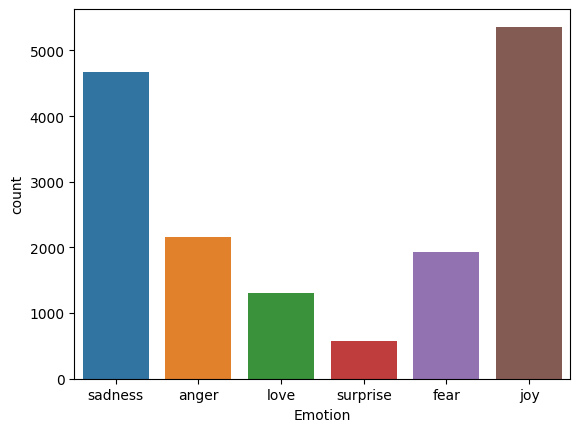

In [ ]:
#Target Classes
sns.countplot(x = "Emotion", data = data_train)

In [ ]:
!pip install text_hammer
import text_hammer as th

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.2
    Uninstalling beautifulsoup4-4.11.2:
      Successfully uninstalled beautifulsoup4-4.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.28 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


In [ ]:
%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 1.81 ms, sys: 75 µs, total: 1.89 ms
Wall time: 4.44 ms


In [ ]:
data_cleaned_train = text_preprocessing(data_train, 'Description')

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

In [ ]:
data_cleaned_test = text_preprocessing(data_test, 'Description')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
data_cleaned_val = text_preprocessing(data_val, 'Description')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
data_cleaned_train['Emotion'] = data_cleaned_train.Emotion.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
data_test['Emotion'] = data_test.Emotion.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
data_val['Emotion'] = data_val.Emotion.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(data_cleaned_train.Emotion.values)
y_test = to_categorical(data_test.Emotion.values)
y_val = to_categorical(data_val.Emotion.values)

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 10000 unique words can be taken
tokenizer=Tokenizer(num_words,lower=True)
data_total = pd.concat([data_cleaned_train['Description'], data_test.Description], axis = 0)
tokenizer.fit_on_texts(data_total)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train=tokenizer.texts_to_sequences(data_cleaned_train['Description']) # this converts texts into some numeric sequences
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post') # this makes the length of all numeric sequences equal
X_test = tokenizer.texts_to_sequences(data_test.Description)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(data_val.Description)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [ ]:
import gensim

In [ ]:
import gensim.downloader as api

In [ ]:
gensim.downloader.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [ ]:
word2vec_gensim  = api.load('word2vec-google-news-300')

In [ ]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

(10000, 300)

In [ ]:
for word, index in tokenizer.word_index.items():
    if index < num_words:  # Since index starts with zero
        if word in word2vec_gensim.key_to_index:
            gensim_weight_matrix[index] = word2vec_gensim[word]
        else:
            # Handle the case where the word is not in the pre-trained embeddings
            gensim_weight_matrix[index] = np.zeros(vector_size)  # You can use zeros or other values as needed
    else:
        break  # Stop if the index exceeds the vocabulary size

In [ ]:
gensim_weight_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.22558594, -0.01953125,  0.09082031, ...,  0.02819824,
        -0.17773438, -0.00604248],
       [-0.05566406,  0.01373291, -0.14160156, ...,  0.00250244,
         0.16699219, -0.06835938],
       ...,
       [ 0.04516602, -0.01318359,  0.05932617, ...,  0.046875  ,
         0.13867188, -0.2109375 ],
       [-0.07958984, -0.46289062,  0.2265625 , ...,  0.19628906,
        -0.265625  , -0.06933594],
       [ 0.0055542 , -0.01074219, -0.49414062, ...,  0.10302734,
        -0.17871094, -0.19921875]])

# Emotion Detection Model

In [ ]:
EMBEDDING_DIM = 300
class_num = 6
model = Sequential()
model.add(Embedding(input_dim = num_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(class_num, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [ ]:
#EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
history_embedding = model.fit(X_train_pad, y_train,
                                epochs = 10, batch_size = 120,
                                validation_data=(X_val_pad, y_val),
                                verbose = 1, callbacks= [es, mc])

Epoch 1/10
134/134 [==============================] - ETA: 0s - loss: 1.2645 - accuracy: 0.5293
Epoch 1: val_accuracy improved from -inf to 0.64800, saving model to ./model.h5
134/134 [==============================] - 1113s 8s/step - loss: 1.2645 - accuracy: 0.5293 - val_loss: 0.9759 - val_accuracy: 0.6480
Epoch 2/10
134/134 [==============================] - ETA: 0s - loss: 0.8111 - accuracy: 0.7117
Epoch 2: val_accuracy improved from 0.64800 to 0.76700, saving model to ./model.h5
134/134 [==============================] - 1131s 8s/step - loss: 0.8111 - accuracy: 0.7117 - val_loss: 0.6564 - val_accuracy: 0.7670
Epoch 3/10
134/134 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.7970
Epoch 3: val_accuracy improved from 0.76700 to 0.84100, saving model to ./model.h5
134/134 [==============================] - 1131s 8s/step - loss: 0.5551 - accuracy: 0.7970 - val_loss: 0.4315 - val_accuracy: 0.8410
Epoch 4/10
134/134 [==============================] - ETA: 0s - los

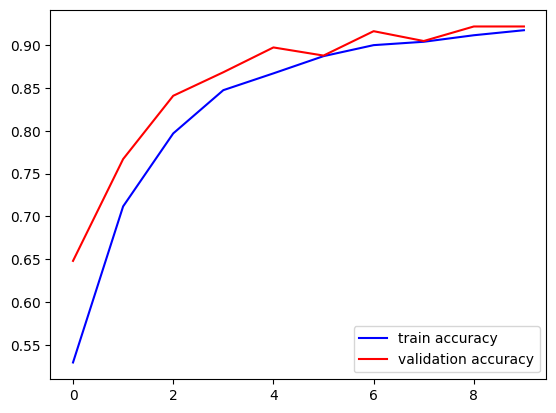

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

63/63 [==============================] - 68s 1s/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       687
           1       0.93      0.90      0.92       284
           2       0.84      0.75      0.79       179
           3       0.95      0.92      0.94       598
           4       0.88      0.91      0.89       215
           5       0.53      0.95      0.68        37

    accuracy                           0.91      2000
   macro avg       0.84      0.89      0.86      2000
weighted avg       0.91      0.91      0.91      2000

